In [11]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
# Define a parser function to parse dates
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

In [13]:
# Load the dataset with parsed dates
sales = pd.read_csv('train.csv', parse_dates=[0], date_parser=parser)

In [14]:
# Set 'date' column as the index and create 'month' and 'year' columns
sales = sales.set_index('date')
sales['month'] = sales.index.month
sales['year'] = sales.index.year
print(len(sales))
sales.head()


913000


,store,item,sales,month,year
date,,,,,
2013-01-01,1,1,13,1,2013
2013-01-02,1,1,11,1,2013
2013-01-03,1,1,14,1,2013
2013-01-04,1,1,13,1,2013
2013-01-05,1,1,10,1,2013


In [10]:
sales['store'] = sales['store'].astype(str)
# Initialize lists to store various dataframes
store_list = []

# Separate sales by store for the training set
for i in range(1, 11):
    store = sales[sales.store == str(i)]
    store_list.append(store)
    print(f"Store {i} data length: {len(store)}")  # Check if stores are being filtered correctly

# Verify the contents of store_list
for idx, store in enumerate(store_list):
    print(f"Store {idx+1} head:\n", store.head())

Store 1 data length: 91300
Store 2 data length: 91300
Store 3 data length: 91300
Store 4 data length: 91300
Store 5 data length: 91300
Store 6 data length: 91300
Store 7 data length: 91300
Store 8 data length: 91300
Store 9 data length: 91300
Store 10 data length: 91300
Store 1 head:
            store  item  sales  month  year
date                                      
2013-01-01     1     1     13      1  2013
2013-01-02     1     1     11      1  2013
2013-01-03     1     1     14      1  2013
2013-01-04     1     1     13      1  2013
2013-01-05     1     1     10      1  2013
Store 2 head:
            store  item  sales  month  year
date                                      
2013-01-01     2     1     12      1  2013
2013-01-02     2     1     16      1  2013
2013-01-03     2     1     16      1  2013
2013-01-04     2     1     20      1  2013
2013-01-05     2     1     16      1  2013
Store 3 head:
            store  item  sales  month  year
date                                   

In [15]:
# Convert our time series to daily, weekly, and monthly stationary for each store
daily_sales_list = []
weekly_sales_list = []
monthly_sales_list = []

for store in store_list:
    daily_sales = store.resample('D').sum()
    print(f"Daily sales length: {len(daily_sales)}")  # Check if resampling is working
    daily_sales_list.append(daily_sales[['sales']])

for store in store_list:
    weekly_sales = store.resample('W').sum()
    print(f"Weekly sales length: {len(weekly_sales)}")  # Check if resampling is working
    weekly_sales_list.append(weekly_sales[['sales']])

for store in store_list:
    monthly_sales = store.resample('M').sum()
    print(f"Monthly sales length: {len(monthly_sales)}")  # Check if resampling is working
    monthly_sales_list.append(monthly_sales[['sales']])

# Check the lengths of the first resampled datasets
print(len(daily_sales_list[0]))
print(len(weekly_sales_list[0]))
print(len(monthly_sales_list[0]))

Daily sales length: 1826
Daily sales length: 1826
Daily sales length: 1826
Daily sales length: 1826
Daily sales length: 1826
Daily sales length: 1826
Daily sales length: 1826
Daily sales length: 1826
Daily sales length: 1826
Daily sales length: 1826
Weekly sales length: 261
Weekly sales length: 261
Weekly sales length: 261
Weekly sales length: 261
Weekly sales length: 261
Weekly sales length: 261
Weekly sales length: 261
Weekly sales length: 261
Weekly sales length: 261
Weekly sales length: 261
Monthly sales length: 60
Monthly sales length: 60
Monthly sales length: 60
Monthly sales length: 60
Monthly sales length: 60
Monthly sales length: 60
Monthly sales length: 60
Monthly sales length: 60
Monthly sales length: 60
Monthly sales length: 60
1826
261
60


In [16]:
# Train-test split for weekly and monthly sales
W = weekly_sales_list
weekly_sales_train_list = []
weekly_sales_test_list = []

for i in W:
    train_size = int(208)
    weekly_sales_train, weekly_sales_test = i[:train_size], i[train_size:]
    weekly_sales_train_list.append(weekly_sales_train[['sales']])
    weekly_sales_test_list.append(weekly_sales_test[['sales']])

M = monthly_sales_list
monthly_sales_train_list = []
monthly_sales_test_list = []

for i in M:
    train_size = int(48)
    monthly_sales_train, monthly_sales_test = i[:train_size], i[train_size:]
    monthly_sales_train_list.append(monthly_sales_train[['sales']])
    monthly_sales_test_list.append(monthly_sales_test[['sales']])

print(len(weekly_sales_list[0]))
print(len(weekly_sales_train_list[0]))
print(len(weekly_sales_test_list[0]))
print(len(monthly_sales_list[0]))
print(len(monthly_sales_train_list[0]))
print(len(monthly_sales_test_list[0]))

261
208
53
60
48
12


In [25]:
import copy 
from random import random
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA  # Updated import
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
import itertools

# Evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.80)
    train, test = X[:train_size], X[train_size:]
    history = [x for x in train]
    
    predictions = []
    for t in range(len(test)):
        arima = ARIMA(history, order=arima_order)
        arima = arima.fit()
        yhat = arima.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    
    error = sqrt(mean_squared_error(test, predictions))
    return error

# Evaluate multiple ARIMA models to find the best configuration
def evaluate_arima_models(data, p_values, d_values, q_values):
    global best_cfg
    data = data.astype('float32')
    best_score, best_cfg = float("inf"), None
    pdq = list(itertools.product(p_values, d_values, q_values))
    
    for i in pdq:
        try:
            print(f"Trying ARIMA configuration: {i}")  # Diagnostic information
            rmse = evaluate_arima_model(data, i)
            print(f"ARIMA{i} RMSE={rmse:.3f}")  # Diagnostic information
            if rmse < best_score:
                best_score, best_cfg = rmse, i
        except Exception as e:
            print(f"ARIMA{i} failed: {e}")  # Diagnostic information
    
    if best_cfg is not None:
        print(f'Best ARIMA{best_cfg} RMSE={best_score:.3f}')
    else:
        print('No suitable ARIMA model found.')

Store 1:
Trying ARIMA configuration: (0, 1, 0)
ARIMA(0, 1, 0) RMSE=10689.709
Trying ARIMA configuration: (0, 1, 1)
ARIMA(0, 1, 1) RMSE=10506.144
Trying ARIMA configuration: (1, 1, 0)
ARIMA(1, 1, 0) RMSE=10441.744
Trying ARIMA configuration: (1, 1, 1)
ARIMA(1, 1, 1) RMSE=10498.134
Trying ARIMA configuration: (2, 1, 0)
ARIMA(2, 1, 0) RMSE=10597.279
Trying ARIMA configuration: (2, 1, 1)
ARIMA(2, 1, 1) RMSE=8813.145
Trying ARIMA configuration: (3, 1, 0)
ARIMA(3, 1, 0) RMSE=10425.225
Trying ARIMA configuration: (3, 1, 1)
ARIMA(3, 1, 1) RMSE=8494.974
Trying ARIMA configuration: (4, 1, 0)
ARIMA(4, 1, 0) RMSE=10288.383
Trying ARIMA configuration: (4, 1, 1)
ARIMA(4, 1, 1) RMSE=8341.090
Trying ARIMA configuration: (5, 1, 0)
ARIMA(5, 1, 0) RMSE=8365.712
Trying ARIMA configuration: (5, 1, 1)
ARIMA(5, 1, 1) RMSE=8130.211
Trying ARIMA configuration: (6, 1, 0)
ARIMA(6, 1, 0) RMSE=8282.101
Trying ARIMA configuration: (6, 1, 1)
ARIMA(6, 1, 1) RMSE=7676.219
Trying ARIMA configuration: (7, 1, 0)
ARIMA(7,

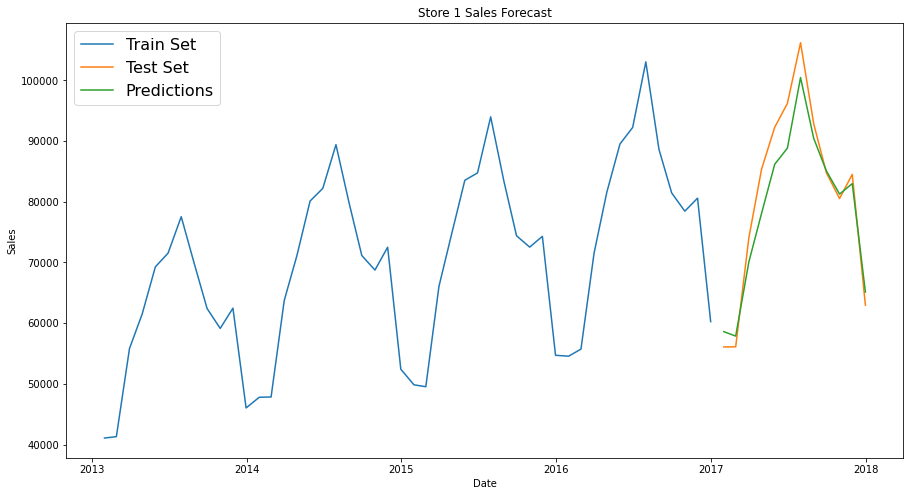

Store 2:
Trying ARIMA configuration: (0, 1, 0)
ARIMA(0, 1, 0) RMSE=14989.166
Trying ARIMA configuration: (0, 1, 1)
ARIMA(0, 1, 1) RMSE=14673.286
Trying ARIMA configuration: (1, 1, 0)
ARIMA(1, 1, 0) RMSE=14570.497
Trying ARIMA configuration: (1, 1, 1)
ARIMA(1, 1, 1) RMSE=14671.077
Trying ARIMA configuration: (2, 1, 0)
ARIMA(2, 1, 0) RMSE=14837.009
Trying ARIMA configuration: (2, 1, 1)
ARIMA(2, 1, 1) RMSE=12260.505
Trying ARIMA configuration: (3, 1, 0)
ARIMA(3, 1, 0) RMSE=14621.921
Trying ARIMA configuration: (3, 1, 1)
ARIMA(3, 1, 1) RMSE=11793.106
Trying ARIMA configuration: (4, 1, 0)
ARIMA(4, 1, 0) RMSE=14305.794
Trying ARIMA configuration: (4, 1, 1)
ARIMA(4, 1, 1) RMSE=11371.198
Trying ARIMA configuration: (5, 1, 0)
ARIMA(5, 1, 0) RMSE=11384.545
Trying ARIMA configuration: (5, 1, 1)
ARIMA(5, 1, 1) RMSE=11545.589
Trying ARIMA configuration: (6, 1, 0)
ARIMA(6, 1, 0) RMSE=11223.571
Trying ARIMA configuration: (6, 1, 1)
ARIMA(6, 1, 1) RMSE=10377.688
Trying ARIMA configuration: (7, 1, 0)
A

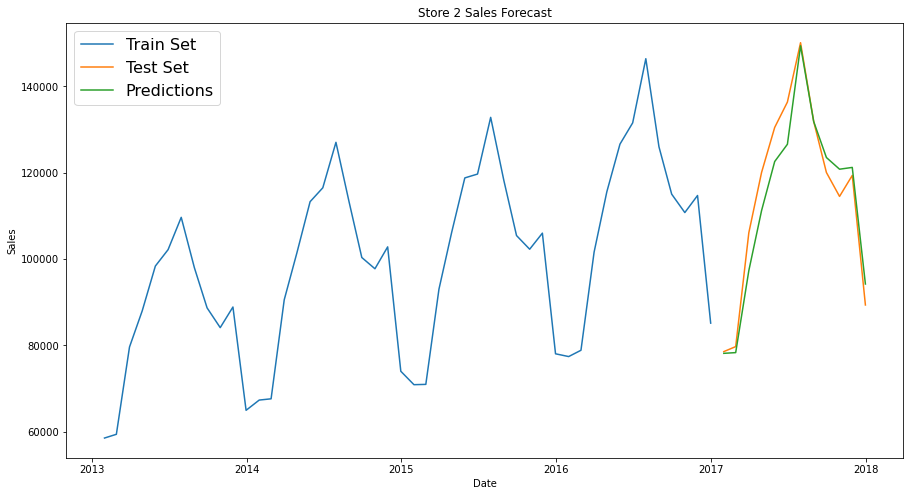

Store 3:
Trying ARIMA configuration: (0, 1, 0)
ARIMA(0, 1, 0) RMSE=13283.193
Trying ARIMA configuration: (0, 1, 1)
ARIMA(0, 1, 1) RMSE=13056.312
Trying ARIMA configuration: (1, 1, 0)
ARIMA(1, 1, 0) RMSE=12971.377
Trying ARIMA configuration: (1, 1, 1)
ARIMA(1, 1, 1) RMSE=13025.267
Trying ARIMA configuration: (2, 1, 0)
ARIMA(2, 1, 0) RMSE=13049.329
Trying ARIMA configuration: (2, 1, 1)
ARIMA(2, 1, 1) RMSE=10724.674
Trying ARIMA configuration: (3, 1, 0)
ARIMA(3, 1, 0) RMSE=12780.620
Trying ARIMA configuration: (3, 1, 1)
ARIMA(3, 1, 1) RMSE=10323.869
Trying ARIMA configuration: (4, 1, 0)
ARIMA(4, 1, 0) RMSE=12596.653
Trying ARIMA configuration: (4, 1, 1)
ARIMA(4, 1, 1) RMSE=10115.026
Trying ARIMA configuration: (5, 1, 0)
ARIMA(5, 1, 0) RMSE=10101.174
Trying ARIMA configuration: (5, 1, 1)
ARIMA(5, 1, 1) RMSE=9537.829
Trying ARIMA configuration: (6, 1, 0)
ARIMA(6, 1, 0) RMSE=9970.619
Trying ARIMA configuration: (6, 1, 1)
ARIMA(6, 1, 1) RMSE=9261.905
Trying ARIMA configuration: (7, 1, 0)
ARIM

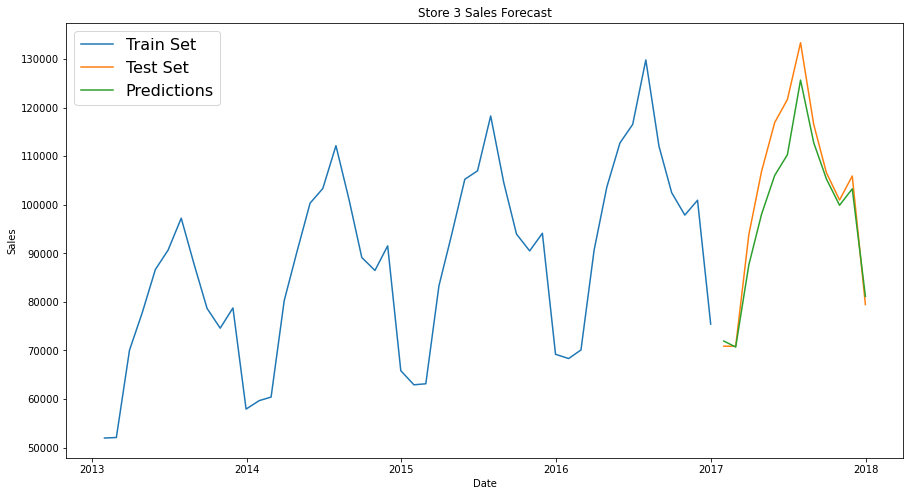

Store 4:
Trying ARIMA configuration: (0, 1, 0)
ARIMA(0, 1, 0) RMSE=12157.628
Trying ARIMA configuration: (0, 1, 1)
ARIMA(0, 1, 1) RMSE=11914.658
Trying ARIMA configuration: (1, 1, 0)
ARIMA(1, 1, 0) RMSE=11827.258
Trying ARIMA configuration: (1, 1, 1)
ARIMA(1, 1, 1) RMSE=11892.433
Trying ARIMA configuration: (2, 1, 0)
ARIMA(2, 1, 0) RMSE=11991.668
Trying ARIMA configuration: (2, 1, 1)
ARIMA(2, 1, 1) RMSE=9801.010
Trying ARIMA configuration: (3, 1, 0)
ARIMA(3, 1, 0) RMSE=11769.682
Trying ARIMA configuration: (3, 1, 1)
ARIMA(3, 1, 1) RMSE=9407.865
Trying ARIMA configuration: (4, 1, 0)
ARIMA(4, 1, 0) RMSE=11572.110
Trying ARIMA configuration: (4, 1, 1)
ARIMA(4, 1, 1) RMSE=9126.187
Trying ARIMA configuration: (5, 1, 0)
ARIMA(5, 1, 0) RMSE=9201.400
Trying ARIMA configuration: (5, 1, 1)
ARIMA(5, 1, 1) RMSE=8329.017
Trying ARIMA configuration: (6, 1, 0)
ARIMA(6, 1, 0) RMSE=9114.907
Trying ARIMA configuration: (6, 1, 1)
ARIMA(6, 1, 1) RMSE=8421.736
Trying ARIMA configuration: (7, 1, 0)
ARIMA(7,

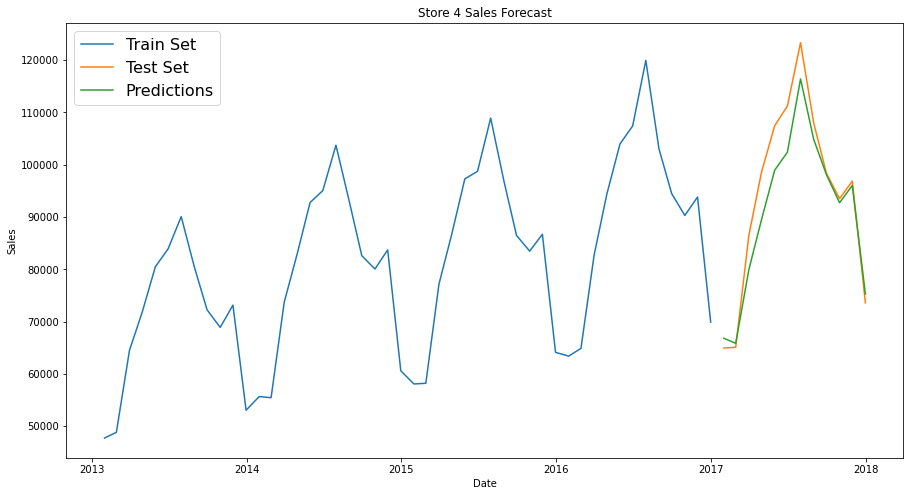

Store 5:
Trying ARIMA configuration: (0, 1, 0)
ARIMA(0, 1, 0) RMSE=8927.184
Trying ARIMA configuration: (0, 1, 1)
ARIMA(0, 1, 1) RMSE=8747.248
Trying ARIMA configuration: (1, 1, 0)
ARIMA(1, 1, 0) RMSE=8682.151
Trying ARIMA configuration: (1, 1, 1)
ARIMA(1, 1, 1) RMSE=8731.225
Trying ARIMA configuration: (2, 1, 0)
ARIMA(2, 1, 0) RMSE=8802.655
Trying ARIMA configuration: (2, 1, 1)
ARIMA(2, 1, 1) RMSE=7234.797
Trying ARIMA configuration: (3, 1, 0)
ARIMA(3, 1, 0) RMSE=8623.809
Trying ARIMA configuration: (3, 1, 1)
ARIMA(3, 1, 1) RMSE=6892.578
Trying ARIMA configuration: (4, 1, 0)
ARIMA(4, 1, 0) RMSE=8467.636
Trying ARIMA configuration: (4, 1, 1)
ARIMA(4, 1, 1) RMSE=6750.398
Trying ARIMA configuration: (5, 1, 0)
ARIMA(5, 1, 0) RMSE=6832.533
Trying ARIMA configuration: (5, 1, 1)
ARIMA(5, 1, 1) RMSE=6026.593
Trying ARIMA configuration: (6, 1, 0)
ARIMA(6, 1, 0) RMSE=6743.400
Trying ARIMA configuration: (6, 1, 1)
ARIMA(6, 1, 1) RMSE=6232.619
Trying ARIMA configuration: (7, 1, 0)
ARIMA(7, 1, 0) 

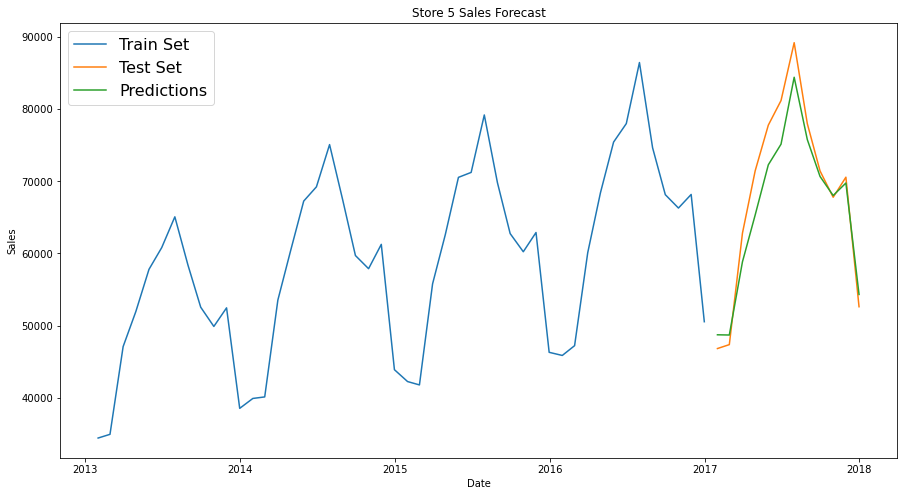

Store 6:
Trying ARIMA configuration: (0, 1, 0)
ARIMA(0, 1, 0) RMSE=9067.677
Trying ARIMA configuration: (0, 1, 1)
ARIMA(0, 1, 1) RMSE=8901.937
Trying ARIMA configuration: (1, 1, 0)
ARIMA(1, 1, 0) RMSE=8847.028
Trying ARIMA configuration: (1, 1, 1)
ARIMA(1, 1, 1) RMSE=8898.506
Trying ARIMA configuration: (2, 1, 0)
ARIMA(2, 1, 0) RMSE=9015.586
Trying ARIMA configuration: (2, 1, 1)
ARIMA(2, 1, 1) RMSE=7503.190
Trying ARIMA configuration: (3, 1, 0)
ARIMA(3, 1, 0) RMSE=8896.368
Trying ARIMA configuration: (3, 1, 1)
ARIMA(3, 1, 1) RMSE=7236.403
Trying ARIMA configuration: (4, 1, 0)
ARIMA(4, 1, 0) RMSE=8733.131
Trying ARIMA configuration: (4, 1, 1)
ARIMA(4, 1, 1) RMSE=6993.407
Trying ARIMA configuration: (5, 1, 0)
ARIMA(5, 1, 0) RMSE=6933.470
Trying ARIMA configuration: (5, 1, 1)
ARIMA(5, 1, 1) RMSE=6391.424
Trying ARIMA configuration: (6, 1, 0)
ARIMA(6, 1, 0) RMSE=6850.947
Trying ARIMA configuration: (6, 1, 1)
ARIMA(6, 1, 1) RMSE=6348.733
Trying ARIMA configuration: (7, 1, 0)
ARIMA(7, 1, 0) 

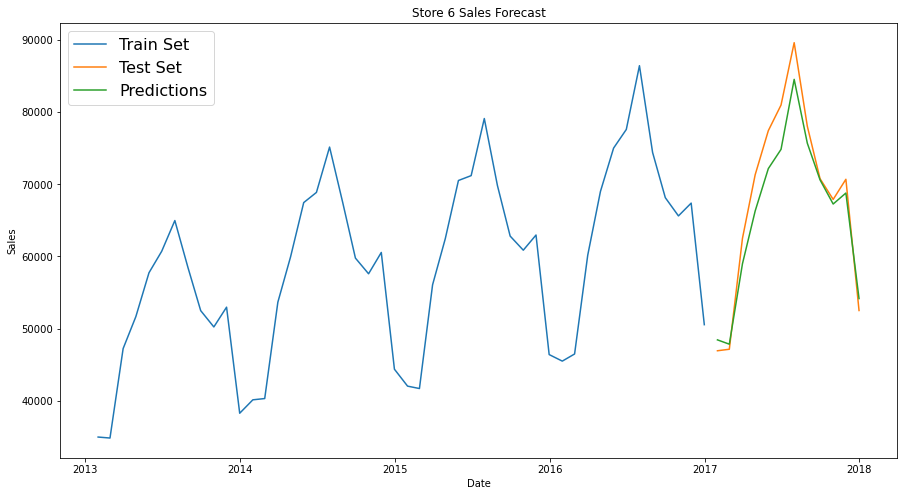

Store 7:
Trying ARIMA configuration: (0, 1, 0)
ARIMA(0, 1, 0) RMSE=8143.633
Trying ARIMA configuration: (0, 1, 1)
ARIMA(0, 1, 1) RMSE=7965.653
Trying ARIMA configuration: (1, 1, 0)
ARIMA(1, 1, 0) RMSE=7903.852
Trying ARIMA configuration: (1, 1, 1)
ARIMA(1, 1, 1) RMSE=7955.309
Trying ARIMA configuration: (2, 1, 0)
ARIMA(2, 1, 0) RMSE=8064.585
Trying ARIMA configuration: (2, 1, 1)
ARIMA(2, 1, 1) RMSE=6703.157
Trying ARIMA configuration: (3, 1, 0)
ARIMA(3, 1, 0) RMSE=7930.814
Trying ARIMA configuration: (3, 1, 1)
ARIMA(3, 1, 1) RMSE=6449.155
Trying ARIMA configuration: (4, 1, 0)
ARIMA(4, 1, 0) RMSE=7801.140
Trying ARIMA configuration: (4, 1, 1)
ARIMA(4, 1, 1) RMSE=6338.882
Trying ARIMA configuration: (5, 1, 0)
ARIMA(5, 1, 0) RMSE=6328.426
Trying ARIMA configuration: (5, 1, 1)
ARIMA(5, 1, 1) RMSE=6010.943
Trying ARIMA configuration: (6, 1, 0)
ARIMA(6, 1, 0) RMSE=6216.120
Trying ARIMA configuration: (6, 1, 1)
ARIMA(6, 1, 1) RMSE=5756.764
Trying ARIMA configuration: (7, 1, 0)
ARIMA(7, 1, 0) 

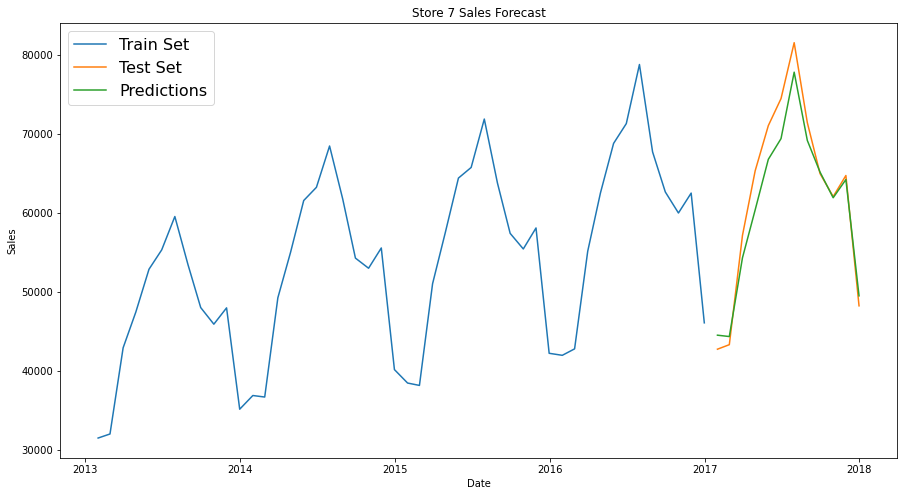

Store 8:
Trying ARIMA configuration: (0, 1, 0)
ARIMA(0, 1, 0) RMSE=14213.559
Trying ARIMA configuration: (0, 1, 1)
ARIMA(0, 1, 1) RMSE=13888.814
Trying ARIMA configuration: (1, 1, 0)
ARIMA(1, 1, 0) RMSE=13778.597
Trying ARIMA configuration: (1, 1, 1)
ARIMA(1, 1, 1) RMSE=13873.736
Trying ARIMA configuration: (2, 1, 0)
ARIMA(2, 1, 0) RMSE=14107.832
Trying ARIMA configuration: (2, 1, 1)
ARIMA(2, 1, 1) RMSE=11846.127
Trying ARIMA configuration: (3, 1, 0)
ARIMA(3, 1, 0) RMSE=13926.425
Trying ARIMA configuration: (3, 1, 1)
ARIMA(3, 1, 1) RMSE=11453.571
Trying ARIMA configuration: (4, 1, 0)
ARIMA(4, 1, 0) RMSE=13710.746
Trying ARIMA configuration: (4, 1, 1)
ARIMA(4, 1, 1) RMSE=11159.083
Trying ARIMA configuration: (5, 1, 0)
ARIMA(5, 1, 0) RMSE=11083.097
Trying ARIMA configuration: (5, 1, 1)
ARIMA(5, 1, 1) RMSE=10998.583
Trying ARIMA configuration: (6, 1, 0)
ARIMA(6, 1, 0) RMSE=10947.916
Trying ARIMA configuration: (6, 1, 1)
ARIMA(6, 1, 1) RMSE=10126.806
Trying ARIMA configuration: (7, 1, 0)
A

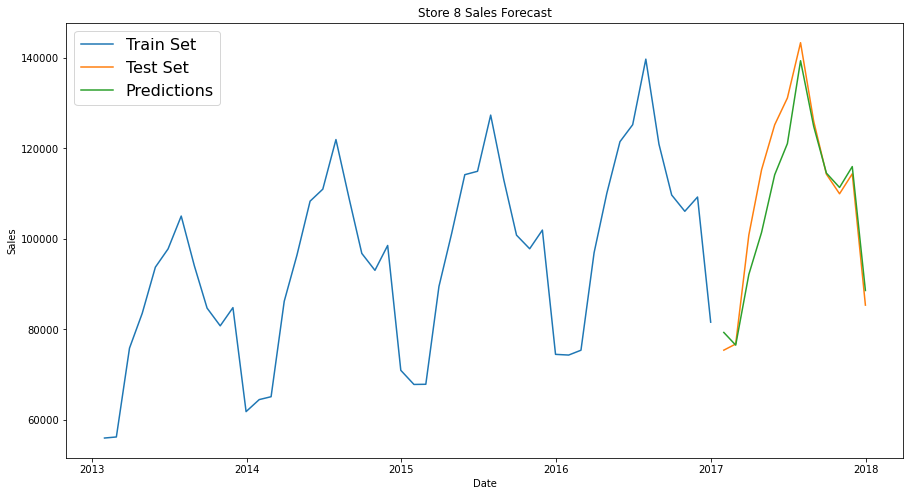

Store 9:
Trying ARIMA configuration: (0, 1, 0)
ARIMA(0, 1, 0) RMSE=12152.911
Trying ARIMA configuration: (0, 1, 1)
ARIMA(0, 1, 1) RMSE=11933.975
Trying ARIMA configuration: (1, 1, 0)
ARIMA(1, 1, 0) RMSE=11848.802
Trying ARIMA configuration: (1, 1, 1)
ARIMA(1, 1, 1) RMSE=11891.884
Trying ARIMA configuration: (2, 1, 0)
ARIMA(2, 1, 0) RMSE=11932.180
Trying ARIMA configuration: (2, 1, 1)
ARIMA(2, 1, 1) RMSE=9803.384
Trying ARIMA configuration: (3, 1, 0)
ARIMA(3, 1, 0) RMSE=11678.562
Trying ARIMA configuration: (3, 1, 1)
ARIMA(3, 1, 1) RMSE=9518.868
Trying ARIMA configuration: (4, 1, 0)
ARIMA(4, 1, 0) RMSE=11546.101
Trying ARIMA configuration: (4, 1, 1)
ARIMA(4, 1, 1) RMSE=9306.990
Trying ARIMA configuration: (5, 1, 0)
ARIMA(5, 1, 0) RMSE=9370.876
Trying ARIMA configuration: (5, 1, 1)
ARIMA(5, 1, 1) RMSE=8681.763
Trying ARIMA configuration: (6, 1, 0)
ARIMA(6, 1, 0) RMSE=9257.669
Trying ARIMA configuration: (6, 1, 1)
ARIMA(6, 1, 1) RMSE=8540.325
Trying ARIMA configuration: (7, 1, 0)
ARIMA(7,

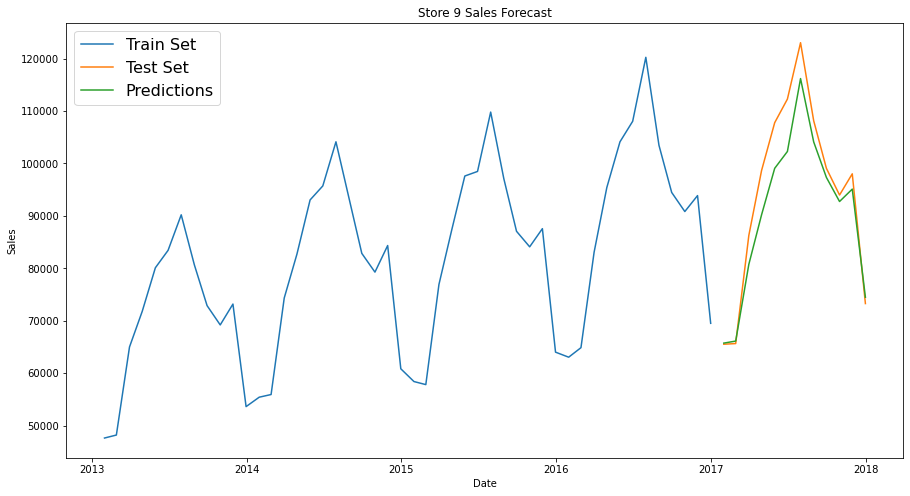

Store 10:
Trying ARIMA configuration: (0, 1, 0)
ARIMA(0, 1, 0) RMSE=13163.767
Trying ARIMA configuration: (0, 1, 1)
ARIMA(0, 1, 1) RMSE=12898.971
Trying ARIMA configuration: (1, 1, 0)
ARIMA(1, 1, 0) RMSE=12812.754
Trying ARIMA configuration: (1, 1, 1)
ARIMA(1, 1, 1) RMSE=12892.668
Trying ARIMA configuration: (2, 1, 0)
ARIMA(2, 1, 0) RMSE=13011.089
Trying ARIMA configuration: (2, 1, 1)
ARIMA(2, 1, 1) RMSE=10811.101
Trying ARIMA configuration: (3, 1, 0)
ARIMA(3, 1, 0) RMSE=12841.778
Trying ARIMA configuration: (3, 1, 1)
ARIMA(3, 1, 1) RMSE=10393.736
Trying ARIMA configuration: (4, 1, 0)
ARIMA(4, 1, 0) RMSE=12647.276
Trying ARIMA configuration: (4, 1, 1)
ARIMA(4, 1, 1) RMSE=10070.032
Trying ARIMA configuration: (5, 1, 0)
ARIMA(5, 1, 0) RMSE=10211.316
Trying ARIMA configuration: (5, 1, 1)
ARIMA(5, 1, 1) RMSE=9893.840
Trying ARIMA configuration: (6, 1, 0)
ARIMA(6, 1, 0) RMSE=10131.568
Trying ARIMA configuration: (6, 1, 1)
ARIMA(6, 1, 1) RMSE=9338.038
Trying ARIMA configuration: (7, 1, 0)
AR

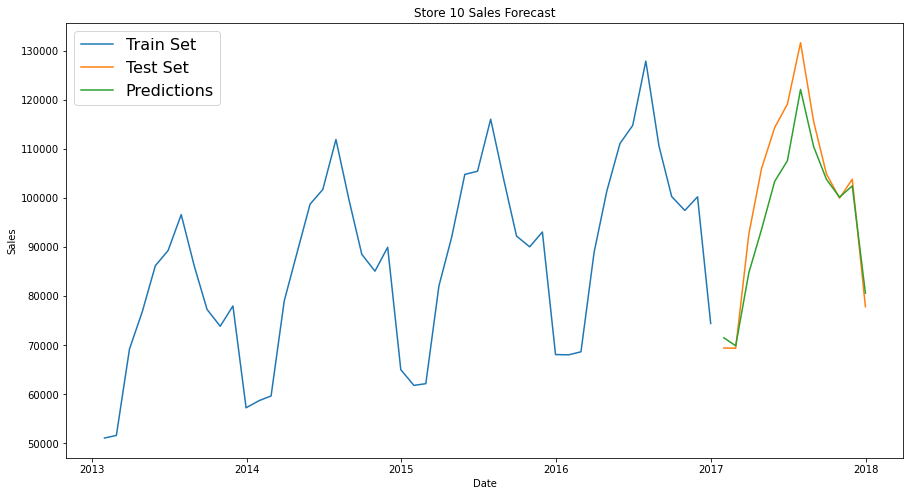


Summary of ARIMA Model Results:

Store 1: Best ARIMA model RMSE = 4240.157
Store 2: Best ARIMA model RMSE = 5735.732
Store 3: Best ARIMA model RMSE = 6137.693
Store 4: Best ARIMA model RMSE = 5342.640
Store 5: Best ARIMA model RMSE = 3623.488
Store 6: Best ARIMA model RMSE = 3466.017
Store 7: Best ARIMA model RMSE = 2909.189
Store 8: Best ARIMA model RMSE = 6690.626
Store 9: Best ARIMA model RMSE = 5442.512
Store 10: Best ARIMA model RMSE = 7082.007


In [28]:
arima_monthly_sales_predictions_list = []
arima_rmse_list = []
arima_monthly_data = []

# ARIMA pipeline function to fit models and make predictions
def arima_pipeline(monthly_sales_by_store, monthly_sales_train, monthly_sales_test):
    for i in range(len(monthly_sales_by_store)):
        print('Store {}:'.format(i+1))
        data = monthly_sales_by_store[i]['sales']
        train = monthly_sales_train[i]['sales']
        test = monthly_sales_test[i]['sales']
        
        # Reduced parameter ranges for quicker evaluation
        p_range = range(0, 13)
        d_range = range(1, 2)
        q_range = range(0, 2)
        
        evaluate_arima_models(data.values, p_range, d_range, q_range)
        
        if best_cfg is not None:
            # Fit ARIMA Model
            if best_cfg[1] == 0:
                sarima = SARIMAX(train, order=best_cfg, enforce_stationarity=False)
            else:
                sarima = SARIMAX(train, order=best_cfg)
            sarima = sarima.fit()

            # Plot predictions
            predictions = sarima.forecast(12)
            arima_monthly_sales_predictions_list.append(predictions)
            error = sqrt(mean_squared_error(test, predictions))
            arima_rmse_list.append(error)

            forecasted_data = pd.DataFrame({'sales': data, 'forecast': sarima.forecast(len(data))})
            arima_monthly_data.append(forecasted_data)
        
            plt.figure(figsize=(15, 8))
            plt.plot(train.index, train, label='Train Set')
            plt.plot(test.index, test, label='Test Set')
            plt.plot(test.index, predictions, label='Predictions')
            plt.title(f"Store {i+1} Sales Forecast")
            plt.xlabel("Date")
            plt.ylabel("Sales")
            plt.legend(loc='upper left', prop={'size': 16})
            plt.show()
        else:
            print(f"No suitable ARIMA model found for Store {i+1}")

# Run the ARIMA pipeline
arima_pipeline(monthly_sales_list, monthly_sales_train_list, monthly_sales_test_list)

# Summarize results
print("\nSummary of ARIMA Model Results:\n")
for i, rmse in enumerate(arima_rmse_list, 1):
    print(f"Store {i}: Best ARIMA model RMSE = {rmse:.3f}")
